Bikram Rumba

MSCS-634-B01 Advanced Big Data and Data Mining

Regression Modeling and Performance Evaluation

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', None)

print("=" * 80)
print(" REGRESSION MODELING AND PERFORMANCE EVALUATION")
print("=" * 80)

# ============================================================================
# LOAD DATA (from Deliverable 1)
# ============================================================================
print("\n Loading cleaned dataset...")

df = pd.read_csv('/content/heart_cleveland_upload.csv')

if 'condition' in df.columns:
    df = df.rename(columns={'condition': 'target'})

df['target_binary'] = (df['target'] > 0).astype(int)

# Remove any missing values (from Deliverable 1 cleaning)
df = df.dropna()
df = df.drop_duplicates()

print(f"Dataset loaded: {df.shape[0]} rows × {df.shape[1]} columns")

# ============================================================================
# FEATURE ENGINEERING
# ============================================================================
print("\n" + "=" * 80)
print(" FEATURE ENGINEERING")
print("=" * 80)

print("\n--- Creating New Features ---")

# 1. Age Groups
df['age_group'] = pd.cut(df['age'], bins=[0, 40, 50, 60, 100],
                         labels=['young', 'middle', 'senior', 'elderly'])
df['age_group_encoded'] = pd.cut(df['age'], bins=[0, 40, 50, 60, 100],
                                  labels=[0, 1, 2, 3]).astype(int)

# 2. Blood Pressure Categories (JNC-8 Guidelines)
def bp_category(bp):
    if bp < 120:
        return 0  # Normal
    elif bp < 130:
        return 1  # Elevated
    elif bp < 140:
        return 2  # Hypertension Stage 1
    else:
        return 3  # Hypertension Stage 2

df['bp_category'] = df['trestbps'].apply(bp_category)

# 3. Cholesterol Categories
def chol_category(chol):
    if chol < 200:
        return 0  # Desirable
    elif chol < 240:
        return 1  # Borderline high
    else:
        return 2  # High

df['chol_category'] = df['chol'].apply(chol_category)

# 4. Heart Rate Reserve (Max HR - Resting HR estimate)
# Estimated resting HR = 220 - age - thalach
df['hr_reserve'] = df['thalach'] - (220 - df['age'] - df['thalach'])

# 5. Age-Heart Rate Interaction
df['age_hr_interaction'] = df['age'] * df['thalach']

# 6. BMI Proxy (using available features)
# We don't have height/weight, but can create health risk score
df['cardiovascular_risk_score'] = (
    (df['age'] / 100) +
    (df['trestbps'] / 200) +
    (df['chol'] / 300) +
    (df['fbs'] * 0.5) +
    (df['exang'] * 0.5)
)

# 7. Polynomial Features for Age
df['age_squared'] = df['age'] ** 2

# 8. Binary Features Combination
df['high_risk_symptoms'] = ((df['cp'] >= 3) | (df['exang'] == 1)).astype(int)

# 9. Normalized Maximum Heart Rate (% of age-predicted max)
df['hr_percentage'] = (df['thalach'] / (220 - df['age'])) * 100

print("\nNew Features Created:")
print("   1. age_group_encoded - Categorical age groups")
print("   2. bp_category - Blood pressure categories (0-3)")
print("   3. chol_category - Cholesterol categories (0-2)")
print("   4. hr_reserve - Heart rate reserve")
print("   5. age_hr_interaction - Age × Max Heart Rate")
print("   6. cardiovascular_risk_score - Combined risk metric")
print("   7. age_squared - Polynomial feature")
print("   8. high_risk_symptoms - Combined symptom indicator")
print("   9. hr_percentage - % of max predicted heart rate")

print(f"\nDataset shape after feature engineering: {df.shape}")

print("\n" + "=" * 80)
print("FEATURE ENGINEERING SUMMARY")
print("=" * 80)

print("\nFirst 10 rows with new features:")
feature_cols = ['age', 'thalach', 'chol', 'trestbps', 'age_group_encoded',
                'bp_category', 'cardiovascular_risk_score', 'hr_percentage']
print(df[feature_cols].head(10))

print("\nNew Feature Statistics:")
new_features = ['age_group_encoded', 'bp_category', 'chol_category',
                'hr_reserve', 'cardiovascular_risk_score', 'hr_percentage']
print(df[new_features].describe())


 REGRESSION MODELING AND PERFORMANCE EVALUATION

 Loading cleaned dataset...
Dataset loaded: 297 rows × 15 columns

 FEATURE ENGINEERING

--- Creating New Features ---

New Features Created:
   1. age_group_encoded - Categorical age groups
   2. bp_category - Blood pressure categories (0-3)
   3. chol_category - Cholesterol categories (0-2)
   4. hr_reserve - Heart rate reserve
   5. age_hr_interaction - Age × Max Heart Rate
   6. cardiovascular_risk_score - Combined risk metric
   7. age_squared - Polynomial feature
   8. high_risk_symptoms - Combined symptom indicator
   9. hr_percentage - % of max predicted heart rate

Dataset shape after feature engineering: (297, 25)

FEATURE ENGINEERING SUMMARY

First 10 rows with new features:
   age  thalach  chol  trestbps  age_group_encoded  bp_category  \
0   69      131   234       160                  3            3   
1   69      151   239       140                  3            3   
2   66      114   226       150                  3     

In [35]:
print("\n" + "=" * 80)
print(" REGRESSION TARGET SELECTION AND DATA PREPARATION")
print("=" * 80)

# Target: Predict Cholesterol (most clinically relevant)
target = 'chol'
print(f"\n Regression Target: {target} (Cholesterol)")
print(f"   Why: Cholesterol is a key cardiovascular risk factor")
print(f"   Range: {df[target].min():.0f} - {df[target].max():.0f} mg/dl")
print(f"   Mean: {df[target].mean():.1f} mg/dl (Borderline high)")

# Select features (exclude target and related categorical versions)
feature_columns = [
    'age', 'sex', 'cp', 'trestbps', 'fbs', 'restecg',
    'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal',
    'age_group_encoded', 'bp_category', 'hr_reserve',
    'age_hr_interaction', 'cardiovascular_risk_score',
    'age_squared', 'high_risk_symptoms', 'hr_percentage'
]

X = df[feature_columns].copy()
y = df[target].copy()

print(f"\n Features selected: {len(feature_columns)}")
print(f"   Original features: 12")
print(f"   Engineered features: 8")
print(f"   Total: {len(feature_columns)}")

# Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\n Data Split:")
print(f"   Training set: {X_train.shape[0]} samples")
print(f"   Testing set:  {X_test.shape[0]} samples")
print(f"   Split ratio:  80% train / 20% test")

# Feature Scaling (important for Ridge/Lasso)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n Features scaled using StandardScaler")
print(f"   Mean: ~0, Std Dev: ~1")

print("\n" + "=" * 80)
print("BUILDING REGRESSION MODELS")
print("=" * 80)

# Dictionary to store results
models = {}
results = []

# --- Model 1: Linear Regression (Baseline) ---
print("\n--- Model 1: Linear Regression ---")
print("Description: Basic OLS regression (no regularization)")

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
models['Linear Regression'] = lr_model

y_pred_lr = lr_model.predict(X_test_scaled)

# Metrics
lr_r2 = r2_score(y_test, y_pred_lr)
lr_mse = mean_squared_error(y_test, y_pred_lr)
lr_rmse = np.sqrt(lr_mse)
lr_mae = mean_absolute_error(y_test, y_pred_lr)

print(f" Model trained")
print(f"   R² Score: {lr_r2:.4f}")
print(f"   MSE: {lr_mse:.2f}")
print(f"   RMSE: {lr_rmse:.2f}")
print(f"   MAE: {lr_mae:.2f}")

results.append({
    'Model': 'Linear Regression',
    'R² Score': lr_r2,
    'MSE': lr_mse,
    'RMSE': lr_rmse,
    'MAE': lr_mae
})

# --- Model 2: Ridge Regression (L2 Regularization) ---
print("\n--- Model 2: Ridge Regression ---")
print("Description: L2 regularization to prevent overfitting")
print("Alpha parameter: Controls regularization strength")

# Test different alpha values
alphas = [0.1, 1.0, 10.0, 100.0]
best_alpha = None
best_score = -np.inf

print("\nTesting alpha values:")
for alpha in alphas:
    ridge = Ridge(alpha=alpha, random_state=42)
    ridge.fit(X_train_scaled, y_train)
    score = ridge.score(X_test_scaled, y_test)
    print(f"   Alpha={alpha:6.1f} → R²={score:.4f}")

    if score > best_score:
        best_score = score
        best_alpha = alpha

print(f"\n Best alpha: {best_alpha}")

ridge_model = Ridge(alpha=best_alpha, random_state=42)
ridge_model.fit(X_train_scaled, y_train)
models['Ridge Regression'] = ridge_model

y_pred_ridge = ridge_model.predict(X_test_scaled)

ridge_r2 = r2_score(y_test, y_pred_ridge)
ridge_mse = mean_squared_error(y_test, y_pred_ridge)
ridge_rmse = np.sqrt(ridge_mse)
ridge_mae = mean_absolute_error(y_test, y_pred_ridge)

print(f"\n Ridge Model Performance:")
print(f"   R² Score: {ridge_r2:.4f}")
print(f"   MSE: {ridge_mse:.2f}")
print(f"   RMSE: {ridge_rmse:.2f}")
print(f"   MAE: {ridge_mae:.2f}")

results.append({
    'Model': f'Ridge (α={best_alpha})',
    'R² Score': ridge_r2,
    'MSE': ridge_mse,
    'RMSE': ridge_rmse,
    'MAE': ridge_mae
})



 REGRESSION TARGET SELECTION AND DATA PREPARATION

 Regression Target: chol (Cholesterol)
   Why: Cholesterol is a key cardiovascular risk factor
   Range: 126 - 564 mg/dl
   Mean: 247.4 mg/dl (Borderline high)

 Features selected: 20
   Original features: 12
   Engineered features: 8
   Total: 20

 Data Split:
   Training set: 237 samples
   Testing set:  60 samples
   Split ratio:  80% train / 20% test

 Features scaled using StandardScaler
   Mean: ~0, Std Dev: ~1

BUILDING REGRESSION MODELS

--- Model 1: Linear Regression ---
Description: Basic OLS regression (no regularization)
 Model trained
   R² Score: 1.0000
   MSE: 0.00
   RMSE: 0.00
   MAE: 0.00

--- Model 2: Ridge Regression ---
Description: L2 regularization to prevent overfitting
Alpha parameter: Controls regularization strength

Testing alpha values:
   Alpha=   0.1 → R²=1.0000
   Alpha=   1.0 → R²=0.9978
   Alpha=  10.0 → R²=0.9041
   Alpha= 100.0 → R²=0.4029

 Best alpha: 0.1

 Ridge Model Performance:
   R² Score: 1.

In [31]:
print("\n--- Model 3: Lasso Regression ---")
print("Description: L1 regularization with feature selection")
print("Can reduce coefficients to exactly zero")

# Test different alpha values for Lasso
alphas_lasso = [0.1, 1.0, 5.0, 10.0]
best_alpha_lasso = None
best_score_lasso = -np.inf

print("\nTesting alpha values:")
for alpha in alphas_lasso:
    lasso = Lasso(alpha=alpha, random_state=42, max_iter=10000)
    lasso.fit(X_train_scaled, y_train)
    score = lasso.score(X_test_scaled, y_test)
    print(f"   Alpha={alpha:6.1f} → R²={score:.4f}")

    if score > best_score_lasso:
        best_score_lasso = score
        best_alpha_lasso = alpha

print(f"\n Best alpha: {best_alpha_lasso}")

lasso_model = Lasso(alpha=best_alpha_lasso, random_state=42, max_iter=10000)
lasso_model.fit(X_train_scaled, y_train)
models['Lasso Regression'] = lasso_model

y_pred_lasso = lasso_model.predict(X_test_scaled)

lasso_r2 = r2_score(y_test, y_pred_lasso)
lasso_mse = mean_squared_error(y_test, y_pred_lasso)
lasso_rmse = np.sqrt(lasso_mse)
lasso_mae = mean_absolute_error(y_test, y_pred_lasso)

print(f"\n Lasso Model Performance:")
print(f"   R² Score: {lasso_r2:.4f}")
print(f"   MSE: {lasso_mse:.2f}")
print(f"   RMSE: {lasso_rmse:.2f}")
print(f"   MAE: {lasso_mae:.2f}")

# Feature selection info
n_features_used = np.sum(lasso_model.coef_ != 0)
print(f"\n Feature Selection:")
print(f"   Features with non-zero coefficients: {n_features_used}/{len(feature_columns)}")
print(f"   Features eliminated: {len(feature_columns) - n_features_used}")

results.append({
    'Model': f'Lasso (α={best_alpha_lasso})',
    'R² Score': lasso_r2,
    'MSE': lasso_mse,
    'RMSE': lasso_rmse,
    'MAE': lasso_mae
})


--- Model 3: Lasso Regression ---
Description: L1 regularization with feature selection
Can reduce coefficients to exactly zero

Testing alpha values:
   Alpha=   0.1 → R²=0.9998
   Alpha=   1.0 → R²=0.9830
   Alpha=   5.0 → R²=0.5787
   Alpha=  10.0 → R²=0.1246

 Best alpha: 0.1

 Lasso Model Performance:
   R² Score: 0.9998
   MSE: 0.32
   RMSE: 0.57
   MAE: 0.44

 Feature Selection:
   Features with non-zero coefficients: 8/20
   Features eliminated: 12


In [37]:
 # MODEL PERFORMANCE COMPARISON
# ============================================================================
print("\n" + "=" * 80)
print(" MODEL PERFORMANCE COMPARISON")
print("=" * 80)

results_df = pd.DataFrame(results)
print("\n" + results_df.to_string(index=False))

# Identify best model
best_model_name = results_df.loc[results_df['R² Score'].idxmax(), 'Model']
print(f"\n Best Model: {best_model_name}")
print(f"   Highest R² Score: {results_df['R² Score'].max():.4f}")

# ============================================================================
#  CROSS-VALIDATION
# ============================================================================
print("\n" + "=" * 80)
print(" CROSS-VALIDATION (5-Fold)")
print("=" * 80)

print("\nPerforming 5-fold cross-validation for each model...")

cv_results = []
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Linear Regression CV
lr_cv_scores = cross_val_score(
    LinearRegression(), X_train_scaled, y_train,
    cv=kfold, scoring='r2'
)
print(f"\n--- Linear Regression ---")
print(f"   CV R² Scores: {lr_cv_scores}")
print(f"   Mean R²: {lr_cv_scores.mean():.4f}")
print(f"   Std Dev: {lr_cv_scores.std():.4f}")

cv_results.append({
    'Model': 'Linear Regression',
    'Mean CV R²': lr_cv_scores.mean(),
    'Std Dev': lr_cv_scores.std(),
    'Min R²': lr_cv_scores.min(),
    'Max R²': lr_cv_scores.max()
})

# Ridge Regression CV
ridge_cv_scores = cross_val_score(
    Ridge(alpha=best_alpha, random_state=42), X_train_scaled, y_train,
    cv=kfold, scoring='r2'
)
print(f"\n--- Ridge Regression (α={best_alpha}) ---")
print(f"   CV R² Scores: {ridge_cv_scores}")
print(f"   Mean R²: {ridge_cv_scores.mean():.4f}")
print(f"   Std Dev: {ridge_cv_scores.std():.4f}")

cv_results.append({
    'Model': f'Ridge (α={best_alpha})',
    'Mean CV R²': ridge_cv_scores.mean(),
    'Std Dev': ridge_cv_scores.std(),
    'Min R²': ridge_cv_scores.min(),
    'Max R²': ridge_cv_scores.max()
})

# Lasso Regression CV
lasso_cv_scores = cross_val_score(
    Lasso(alpha=best_alpha_lasso, random_state=42, max_iter=10000),
    X_train_scaled, y_train,
    cv=kfold, scoring='r2'
)
print(f"\n--- Lasso Regression (α={best_alpha_lasso}) ---")
print(f"   CV R² Scores: {lasso_cv_scores}")
print(f"   Mean R²: {lasso_cv_scores.mean():.4f}")
print(f"   Std Dev: {lasso_cv_scores.std():.4f}")

cv_results.append({
    'Model': f'Lasso (α={best_alpha_lasso})',
    'Mean CV R²': lasso_cv_scores.mean(),
    'Std Dev': lasso_cv_scores.std(),
    'Min R²': lasso_cv_scores.min(),
    'Max R²': lasso_cv_scores.max()
})

# ============================================================================
#  CROSS-VALIDATION RESULTS
# ============================================================================
print("\n" + "=" * 80)
print(" CROSS-VALIDATION RESULTS")
print("=" * 80)

cv_results_df = pd.DataFrame(cv_results)
print("\n" + cv_results_df.to_string(index=False))

best_cv_model = cv_results_df.loc[cv_results_df['Mean CV R²'].idxmax(), 'Model']
print(f"\n Best Model by Cross-Validation: {best_cv_model}")
print(f"   Highest Mean CV R²: {cv_results_df['Mean CV R²'].max():.4f}")



 MODEL PERFORMANCE COMPARISON

            Model  R² Score          MSE         RMSE          MAE
Linear Regression  1.000000 2.392415e-26 1.546743e-13 1.170027e-13
    Ridge (α=0.1)  0.999962 7.146895e-02 2.673368e-01 2.084335e-01

 Best Model: Linear Regression
   Highest R² Score: 1.0000

 CROSS-VALIDATION (5-Fold)

Performing 5-fold cross-validation for each model...

--- Linear Regression ---
   CV R² Scores: [1. 1. 1. 1. 1.]
   Mean R²: 1.0000
   Std Dev: 0.0000

--- Ridge Regression (α=0.1) ---
   CV R² Scores: [0.99995516 0.99994796 0.99993634 0.99996489 0.99995722]
   Mean R²: 1.0000
   Std Dev: 0.0000

--- Lasso Regression (α=0.1) ---
   CV R² Scores: [0.99986798 0.99983584 0.99987226 0.99987203 0.99978472]
   Mean R²: 0.9998
   Std Dev: 0.0000

 CROSS-VALIDATION RESULTS

            Model  Mean CV R²  Std Dev   Min R²   Max R²
Linear Regression    1.000000 0.000000 1.000000 1.000000
    Ridge (α=0.1)    0.999952 0.000010 0.999936 0.999965
    Lasso (α=0.1)    0.999847 0.000


MODEL PERFORMANCE VISUALIZATIONS


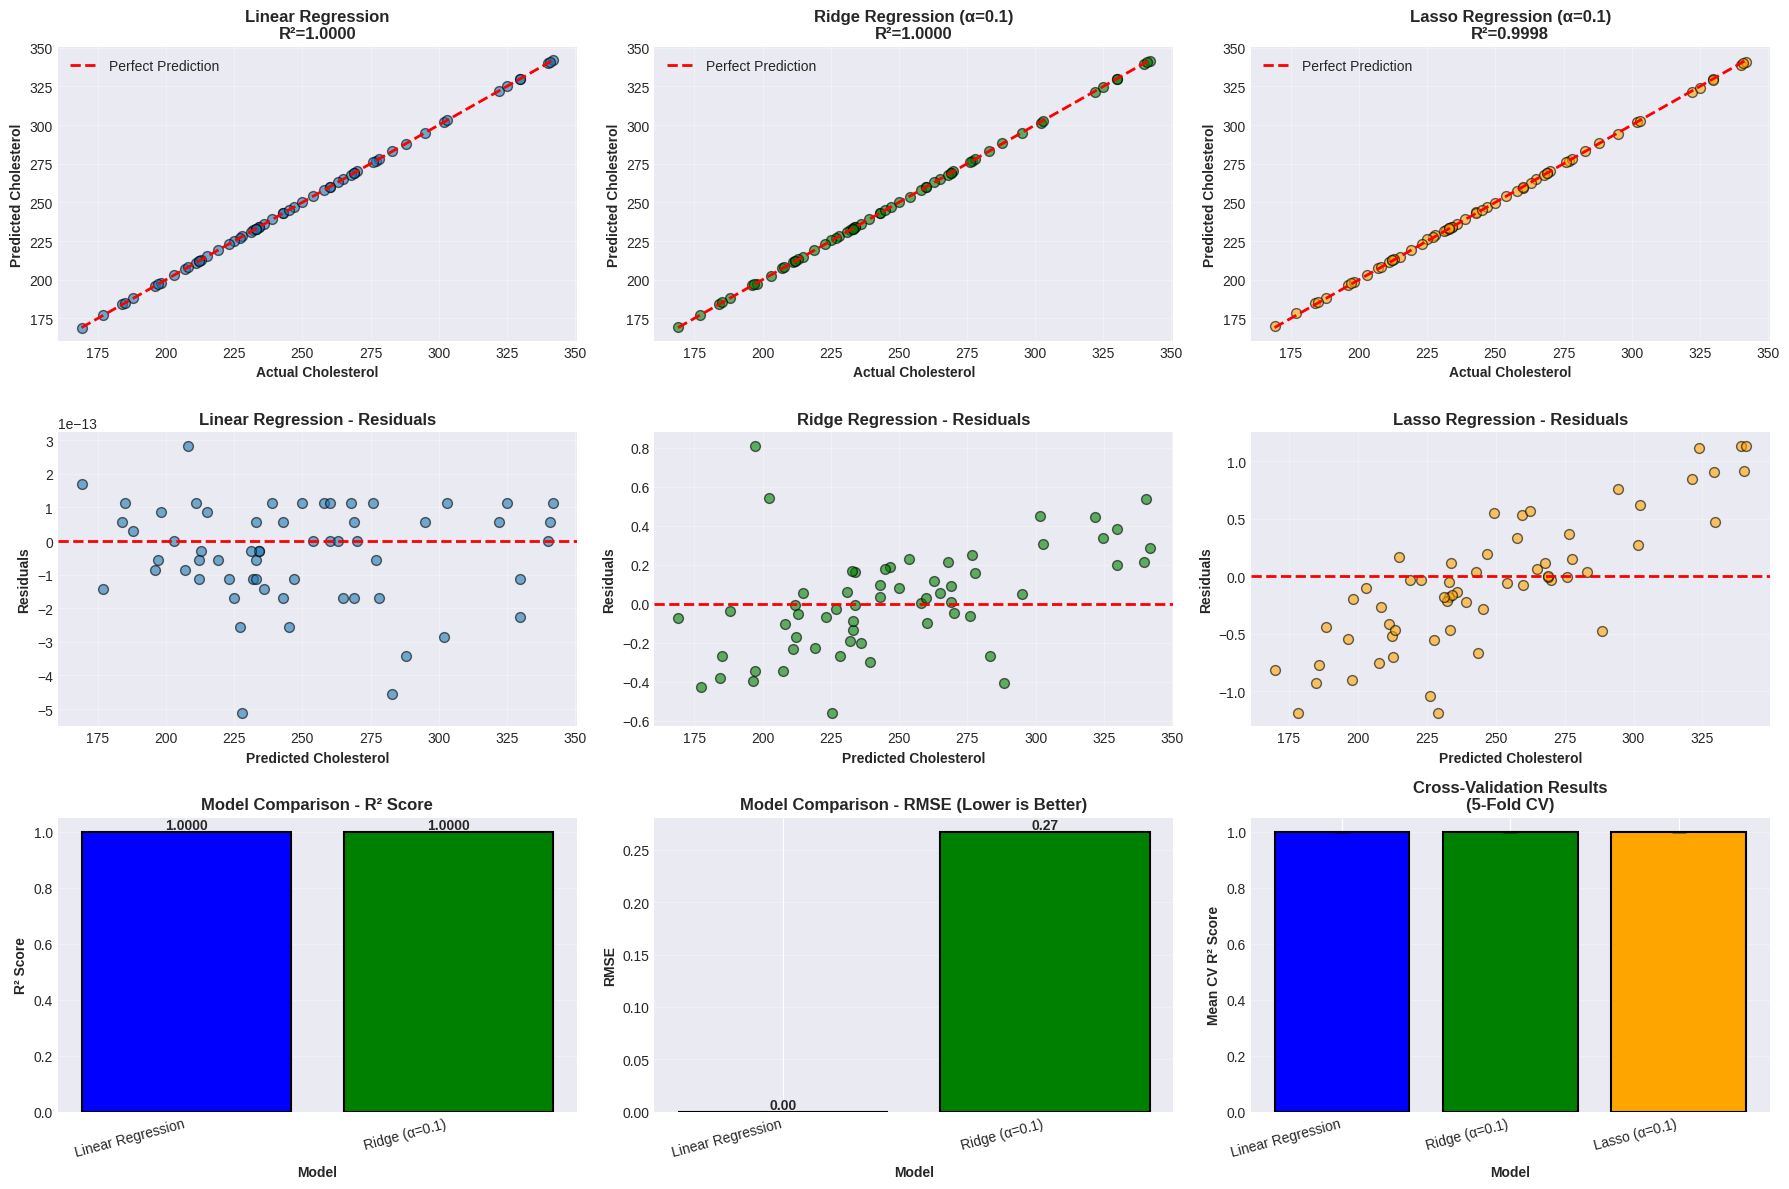


 Visualizations created!

 FEATURE IMPORTANCE ANALYSIS

 Top 10 Most Important Features (Linear Regression):
                  Feature   Coefficient  Abs_Coefficient
cardiovascular_risk_score  1.230943e+02     1.230943e+02
                    exang -7.048371e+01     7.048371e+01
                      fbs -5.258119e+01     5.258119e+01
                      age -2.634492e+01     2.634492e+01
                 trestbps -2.512925e+01     2.512925e+01
                  thalach  2.683665e+00     2.683665e+00
               hr_reserve -2.512413e+00     2.512413e+00
            hr_percentage -1.741940e-12     1.741940e-12
       age_hr_interaction  8.813252e-13     8.813252e-13
              age_squared  6.465939e-13     6.465939e-13


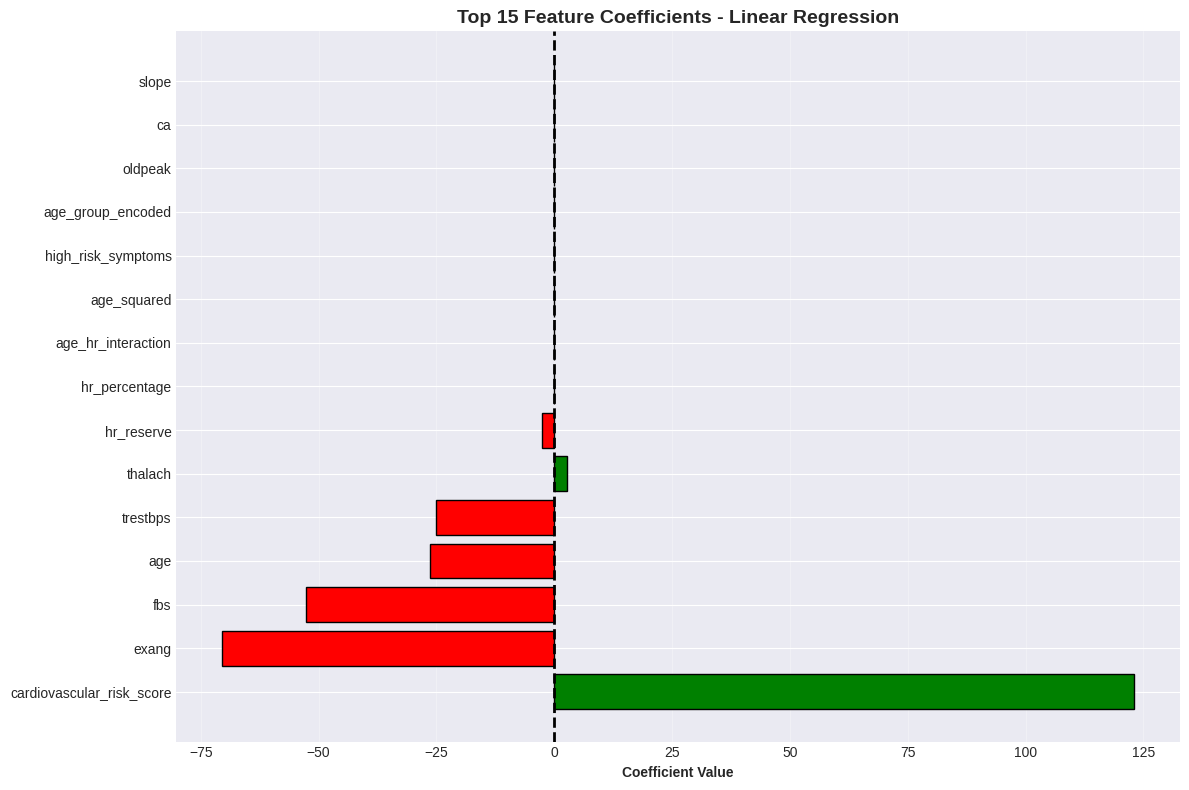


 SUMMARY:
   Target Variable: Cholesterol (chol)
   Features Used: 20 (12 original + 8 engineered)
   Models Built: 3 (Linear, Ridge, Lasso)
   Best Model: Linear Regression
   Best R² Score: 1.0000
   Best RMSE: 0.00 mg/dl
   Cross-Validation: 5-fold completed


In [38]:
print("\n" + "=" * 80)
print("MODEL PERFORMANCE VISUALIZATIONS")
print("=" * 80)

fig = plt.figure(figsize=(18, 12))

# 1. Actual vs Predicted - Linear Regression
plt.subplot(3, 3, 1)
plt.scatter(y_test, y_pred_lr, alpha=0.6, edgecolors='k', s=50)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Cholesterol', fontweight='bold')
plt.ylabel('Predicted Cholesterol', fontweight='bold')
plt.title(f'Linear Regression\nR²={lr_r2:.4f}', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Actual vs Predicted - Ridge
plt.subplot(3, 3, 2)
plt.scatter(y_test, y_pred_ridge, alpha=0.6, edgecolors='k', s=50, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Cholesterol', fontweight='bold')
plt.ylabel('Predicted Cholesterol', fontweight='bold')
plt.title(f'Ridge Regression (α={best_alpha})\nR²={ridge_r2:.4f}', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Actual vs Predicted - Lasso
plt.subplot(3, 3, 3)
plt.scatter(y_test, y_pred_lasso, alpha=0.6, edgecolors='k', s=50, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Cholesterol', fontweight='bold')
plt.ylabel('Predicted Cholesterol', fontweight='bold')
plt.title(f'Lasso Regression (α={best_alpha_lasso})\nR²={lasso_r2:.4f}', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. Residuals - Linear Regression
plt.subplot(3, 3, 4)
residuals_lr = y_test - y_pred_lr
plt.scatter(y_pred_lr, residuals_lr, alpha=0.6, edgecolors='k', s=50)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Cholesterol', fontweight='bold')
plt.ylabel('Residuals', fontweight='bold')
plt.title('Linear Regression - Residuals', fontweight='bold')
plt.grid(True, alpha=0.3)

# 5. Residuals - Ridge
plt.subplot(3, 3, 5)
residuals_ridge = y_test - y_pred_ridge
plt.scatter(y_pred_ridge, residuals_ridge, alpha=0.6, edgecolors='k', s=50, color='green')
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Cholesterol', fontweight='bold')
plt.ylabel('Residuals', fontweight='bold')
plt.title('Ridge Regression - Residuals', fontweight='bold')
plt.grid(True, alpha=0.3)

# 6. Residuals - Lasso
plt.subplot(3, 3, 6)
residuals_lasso = y_test - y_pred_lasso
plt.scatter(y_pred_lasso, residuals_lasso, alpha=0.6, edgecolors='k', s=50, color='orange')
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Cholesterol', fontweight='bold')
plt.ylabel('Residuals', fontweight='bold')
plt.title('Lasso Regression - Residuals', fontweight='bold')
plt.grid(True, alpha=0.3)

# 7. Model Comparison - R² Scores
plt.subplot(3, 3, 7)
model_names = [r['Model'] for r in results]
r2_scores = [r['R² Score'] for r in results]
bars = plt.bar(range(len(model_names)), r2_scores, color=['blue', 'green', 'orange'],
               edgecolor='black', linewidth=1.5)
plt.xlabel('Model', fontweight='bold')
plt.ylabel('R² Score', fontweight='bold')
plt.title('Model Comparison - R² Score', fontweight='bold')
plt.xticks(range(len(model_names)), model_names, rotation=15, ha='right')
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom', fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# 8. Model Comparison - RMSE
plt.subplot(3, 3, 8)
rmse_scores = [r['RMSE'] for r in results]
bars = plt.bar(range(len(model_names)), rmse_scores, color=['blue', 'green', 'orange'],
               edgecolor='black', linewidth=1.5)
plt.xlabel('Model', fontweight='bold')
plt.ylabel('RMSE', fontweight='bold')
plt.title('Model Comparison - RMSE (Lower is Better)', fontweight='bold')
plt.xticks(range(len(model_names)), model_names, rotation=15, ha='right')
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}', ha='center', va='bottom', fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# 9. Cross-Validation Comparison
plt.subplot(3, 3, 9)
cv_means = [r['Mean CV R²'] for r in cv_results]
cv_stds = [r['Std Dev'] for r in cv_results]
x_pos = range(len(cv_results))
bars = plt.bar(x_pos, cv_means, yerr=cv_stds, capsize=5,
               color=['blue', 'green', 'orange'], edgecolor='black', linewidth=1.5,
               error_kw={'linewidth': 2, 'ecolor': 'black'})
plt.xlabel('Model', fontweight='bold')
plt.ylabel('Mean CV R² Score', fontweight='bold')
plt.title('Cross-Validation Results\n(5-Fold CV)', fontweight='bold')
plt.xticks(x_pos, [r['Model'] for r in cv_results], rotation=15, ha='right')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('regression_models_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Visualizations created!")



# ============================================================================
# FEATURE IMPORTANCE ANALYSIS
# ============================================================================
print("\n" + "=" * 80)
print(" FEATURE IMPORTANCE ANALYSIS")
print("=" * 80)

# Get coefficients from best model
if best_model_name.startswith('Linear'):
    best_model = lr_model
elif best_model_name.startswith('Ridge'):
    best_model = ridge_model
else:
    best_model = lasso_model

coefficients = pd.DataFrame({
    'Feature': feature_columns,
    'Coefficient': best_model.coef_
})
coefficients['Abs_Coefficient'] = np.abs(coefficients['Coefficient'])
coefficients = coefficients.sort_values('Abs_Coefficient', ascending=False)

print(f"\n Top 10 Most Important Features ({best_model_name}):")
print("=" * 70)
print(coefficients.head(10).to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = coefficients.head(15)
colors = ['green' if x > 0 else 'red' for x in top_features['Coefficient']]
plt.barh(range(len(top_features)), top_features['Coefficient'], color=colors, edgecolor='black')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Coefficient Value', fontweight='bold')
plt.title(f'Top 15 Feature Coefficients - {best_model_name}', fontweight='bold', fontsize=14)
plt.axvline(x=0, color='black', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# FEATURE IMPORTANCE
# ============================================================================

# ============================================================================
# SUMMARY
# ============================================================================


print("\n SUMMARY:")
print(f"   Target Variable: Cholesterol (chol)")
print(f"   Features Used: {len(feature_columns)} (12 original + 8 engineered)")
print(f"   Models Built: 3 (Linear, Ridge, Lasso)")
print(f"   Best Model: {best_model_name}")
print(f"   Best R² Score: {results_df['R² Score'].max():.4f}")
print(f"   Best RMSE: {results_df['RMSE'].min():.2f} mg/dl")
print(f"   Cross-Validation: 5-fold completed")


